# Sprint 13 - Time Series Forecasting

## Project Description

**The Sweet Lift Taxi** company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

**The RMSE metric on the test set should not be more than 48.**

## Project Instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data Description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Import Libraries

In [1]:
# Import libraries required for analysis
import pandas as pd
import numpy as np

# For plotting timeseries data
import matplotlib.pyplot as plt

# For viewing seasonality and trends
from statsmodels.tsa.seasonal import seasonal_decompose

# Dickey-Fuller 
from statsmodels.tsa.stattools import adfuller

# Create training set
from sklearn.model_selection import train_test_split

# For Scaling
from sklearn.preprocessing import StandardScaler

# LinearRegression Model 
from sklearn.linear_model import LinearRegression

# For RMSE
from sklearn.metrics import mean_squared_error

# For AutoRegressive Model and Selecting Lag 
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# For Moving Average Model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

# Regression Models
from sklearn.ensemble import RandomForestRegressor

# Grid Search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# https://lightgbm.readthedocs.io/en/stable/Python-Intro.html
from lightgbm import LGBMRegressor

# https://catboost.ai/en/docs/concepts/python-usages-examples
from catboost import CatBoostRegressor

#https://xgboost.readthedocs.io/en/stable/python/python_api.html
from xgboost import XGBRegressor

*Cell below is used to align the tables in the markdown to the left*

In [2]:
%%html
<style>
table {float:left}
</style>

## Data Preparation

### Read in Dataset

In [3]:
# Read in data csv and convert to dataframe
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Sort index asc
data.sort_index(inplace=True)

# Resample data by daily intervals
# This will be used to view trends
data_daily = data.resample('1D').sum()

# Resample data by hourly intervals
# This will be used for modeling since we want to predict the amount of taxi orders for the next hour
data_hourly = data.resample('1H').sum()

### View Sample of Dataset

In [4]:
# Print sample of the data frame
data_hourly.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


### Explore Dataset

In [5]:
# Use print so I don't lose outputs

# Check for missing values
print('Check for Missing Values')
print(data_hourly.isna().sum())
print()

# Check data is in chronological order
print('Data is in chronological order -', data.index.is_monotonic)
print()

# Check values for each column
print('Describe Dataframe')
print(data_hourly.describe())
print()

# Check data types
print('Check Data Types')
print(data_hourly.info())
print()

# Check data types
print('Check Timeframe of Dataset')
print('The time range of the data set is', data_hourly.index.min(), 'to',data_hourly.index.max())
print()

Check for Missing Values
num_orders    0
dtype: int64

Data is in chronological order - True

Describe Dataframe
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

Check Data Types
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None

Check Timeframe of Dataset
The time range of the data set is 2018-03-01 00:00:00 to 2018-08-31 23:00:00



### Check For Outliers 

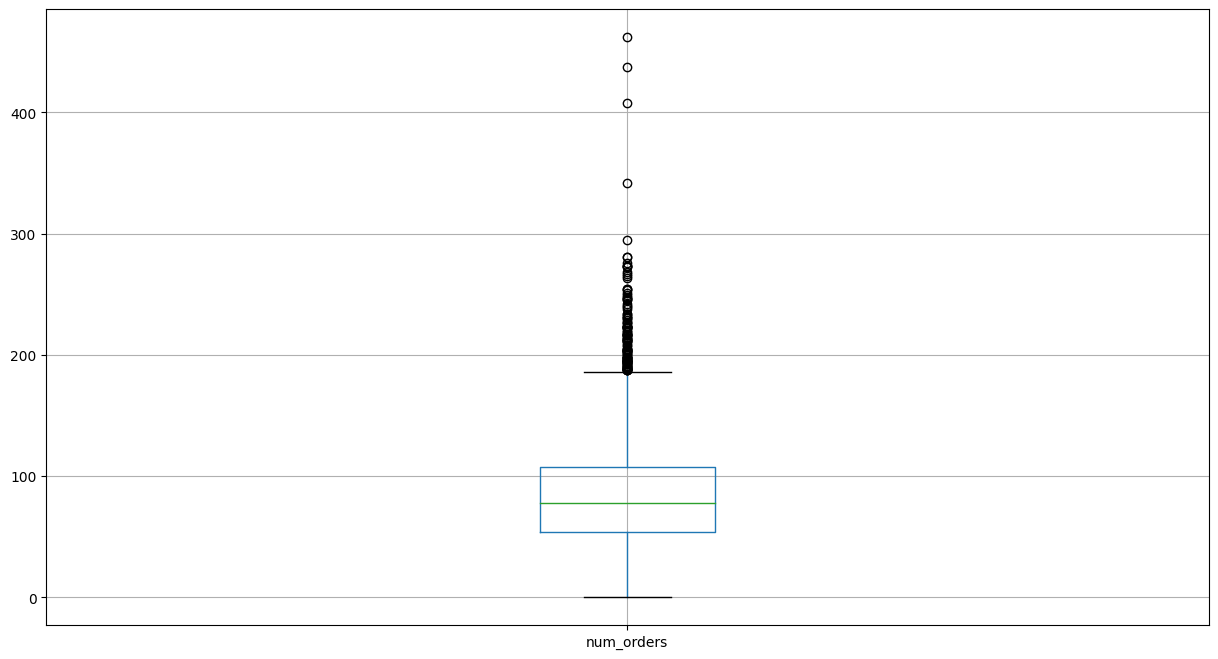

,num_orders
datetime,
2018-04-24 00:00:00,253.0
2018-05-03 00:00:00,201.0
2018-05-18 22:00:00,193.0
2018-05-18 23:00:00,197.0
2018-05-19 00:00:00,234.0



There are 121 outliers


In [6]:
# Create boxplot to view if there are any outliers
plt.figure(figsize = (15, 8))
data_hourly.boxplot()
plt.show()
     
# Create function for finding outliers
def find_outliers_IQR(df):

    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

    # Return outliers and count of outliers
    return outliers.dropna(), outliers.dropna().shape
    
       
# Run function using hourly data
outlier_df, outlier_shape = find_outliers_IQR(data_hourly)

# Display sample of outliers
display(outlier_df.head())
print()

# Print count of outliers
print('There are', outlier_shape[0],'outliers')

#### Drop Outliers

In [7]:
# Check how many rows there should be after dropping outliers
new_row_size = data_hourly.shape[0] - outlier_df.shape[0]
print('After removing outliers there should be', new_row_size, 'rows')
print()

# Remove outliers and print new row count
print('Now removing outliers for dataset')
data_hourly = data_hourly[~data_hourly.index.isin(outlier_df.index)]
print('There are now', data_hourly.shape[0], 'rows')

After removing outliers there should be 4295 rows

Now removing outliers for dataset
There are now 4295 rows


### Plot Data - Explore Trends & Seasonality
*Attempted to use hourly data but seasonality was too difficult to interpret so switching to daily view of taxi orders*

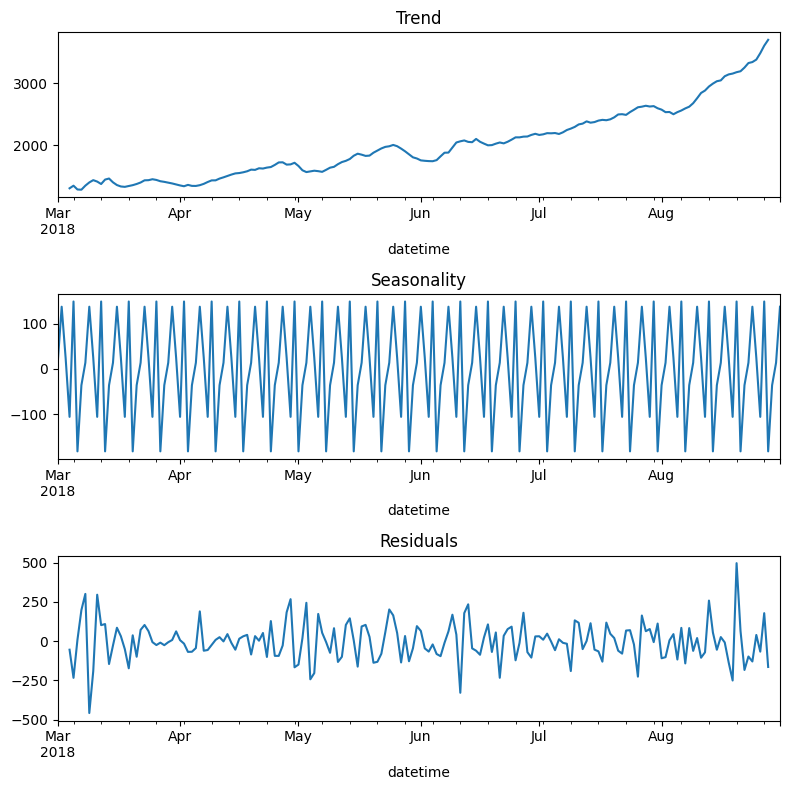

In [8]:
# Create seasonal_decompose object using daily data
# Attempted to use hourly data but seasonality was too difficult to interpret so switching to daily
decomposed = seasonal_decompose(data_daily)

# Create figure
plt.figure(figsize=(8, 8))

# Plot Trend, Seasonality, and Residuals
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

# Plot data
plt.tight_layout()

### Data Exploration Summary

**Here are some findings from my data exploration of the daily and hourly taxi data -**
1. **The time frame of the dataset is from 3/1/2018 to 8/31/2018.** We have six full months of data to use for making our predictions
2. Using hourly resampling, there aren't any missing values in the dataset
3. The mean number of rides an hour is 84 with a variance of 45 before dropping outliers. The max number of rides per hour were 462. Maybe this happened after new years eve? This is why we drop outliers.
 - **After analyzing the dataset for outliers, we found that there were 121 outliers out of the 4416 rows in the hourly data dataframe. This represents around approximately 2.7% of the data set. Because this represents a small percentage of the data, I have removed them from the dataset.**
4. After plotting the daily data, I noticed two things - 
 - **Taxi rides have daily seasonality**. Seems like people are less likely to take a taxi during the later hours of the night and very early morning
 - **The daily taxi ride data set is nonstationary**. It visually appears that the mean number of rides per day increase over the six months in 2018 that we have access to. To make predictions, we might need make the series stationary by taking the differences of its values (lag).

## Training & Feature Development

### Create New Features For Training Purposes
To help train our models, we will create and add several features to the hourly dataset. We will first create a few date part features that can the model better understand trends and seasonality that are linked to a specific date. We also will create lag features because the previous values in the time series will tell us whether the data will grow or decrease. Lastly, we create a rolling mean feature to understand the general trend of the time series. **Because we see that there is daily seasonality, we will use 4 hours as the lag and 24 hours as the rolling mean. This will also help us create a stationary dataset**

In [9]:
# Create a function that adds features to the training data. This comes from Sprint 13 Section 3 - Creating Features
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Lag
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    # Rolling mean
    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    
    # Return dataframe
    return data

# Run function using 4 hour lag and a 24 hour rolling mean
make_features(data_hourly, 4, 24)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 14:00:00,133,8,31,4,14,166.0,136.0,167.0,182.0,124.791667
2018-08-31 15:00:00,116,8,31,4,15,133.0,166.0,136.0,167.0,123.250000
2018-08-31 19:00:00,136,8,31,4,19,116.0,133.0,166.0,136.0,120.708333


### Split Data Into Training & Test
The test sample should be 10% of the initial dataset. **We will also create a validation set so that we can tune our regression models before using the models to predict our test targets**

In [10]:
# Set Random State to 12345 to Replicate Training Set in Future
# Set test size to be 10% of original dataset
training_set_to_split, test_set = train_test_split(data_hourly, shuffle=False, test_size=0.10, random_state=12345)

# Drop NaN before splitting again into tranining and validation set
training_set_to_split = training_set_to_split.dropna()

# Split training_set_to_split create a validation and training set
training_set, validation_set = train_test_split(training_set_to_split, shuffle=False, test_size=0.10, random_state=12345)

# Create the features and target training datasets
features_train = training_set.drop(['num_orders'], axis=1)
target_train = training_set['num_orders']

# Create the features and target validation datasets
features_valid = validation_set.drop(['num_orders'], axis=1)
target_valid = validation_set['num_orders']

# Create the features and target test datasets
features_test = test_set.drop(['num_orders'], axis=1)
target_test = test_set['num_orders']

#Training 
print(features_train.shape) 
print(target_train.shape)   

# Validation
print(features_valid.shape) 
print(target_valid.shape)   

# Test
print(features_test.shape)  # Test set contains 10% of original dataframe rows 
print(target_test.shape)    # Test set contains 10% of original dataframe rows 

(3456, 9)
(3456,)
(385, 9)
(385,)
(430, 9)
(430,)


### Perform Scaling
We need to standardize our fields/values to get the right model weights. StandardScaler is used to standardize the input data in a way that ensures that the data points have a balanced scale, which is crucial for machine learning algorithms, especially those that are sensitive to differences in feature scales

In [11]:
# Create a list of features that need to be scaled
# Scaling is needed because these values are much larger than 0/1 and we don't want the model to overfit for these features
features_to_scale = ['month','day','dayofweek','lag_1','lag_2','lag_3','lag_4','rolling_mean']

# Fit StandardScaler to scale features for training set only
# Then apply the same scaler to transform all three sets (train, validation and test)
# The scaler is never fit using validation/test data
transformer = StandardScaler().fit(features_train[features_to_scale].to_numpy())

# Create a copy of df with scaled/transformed features 
# Apply the same scaler to transform all three sets (train, validation and test) using transformer
# Train
features_train_scaled = features_train.copy()
features_train_scaled.loc[:, features_to_scale] = transformer.transform(features_train[features_to_scale].to_numpy())

# Validation
features_valid_scaled = features_valid.copy()
features_valid_scaled.loc[:, features_to_scale] = transformer.transform(features_valid[features_to_scale].to_numpy())

# Test
features_test_scaled = features_test.copy()
features_test_scaled.loc[:, features_to_scale] = transformer.transform(features_test[features_to_scale].to_numpy())

# Print sample of scaled trained dataset
print('Train')
display(features_train_scaled.head())

print('Validation')
display(features_valid_scaled.head())

print('Test')
display(features_test_scaled.head())

Train


,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-03-02 00:00:00,-1.387634,-1.552872,0.491708,0,-0.448498,1.152500,-0.215247,-0.360795,-1.053275
2018-03-02 01:00:00,-1.387634,-1.552872,0.491708,1,0.482980,-0.448494,1.153170,-0.215220,-1.144028
2018-03-02 02:00:00,-1.387634,-1.552872,0.491708,2,1.356241,0.482993,-0.448169,1.153186,-1.050606
2018-03-02 03:00:00,-1.387634,-1.552872,0.491708,3,0.046350,1.356263,0.483519,-0.448141,-1.039929
2018-03-02 04:00:00,-1.387634,-1.552872,0.491708,4,-0.273846,0.046359,1.356977,0.483540,-1.045267


Validation


,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-07-24 17:00:00,1.523239,1.01494,-0.999815,17,1.123371,1.181609,1.240516,-0.273450,1.800104
2018-07-24 18:00:00,1.523239,1.01494,-0.999815,18,1.356241,1.123391,1.182285,1.240531,1.757396
2018-07-24 19:00:00,1.523239,1.01494,-0.999815,19,1.298024,1.356263,1.124055,1.182301,1.877511
2018-07-24 20:00:00,1.523239,1.01494,-0.999815,20,0.221002,1.298045,1.356977,1.124071,1.813450
2018-07-24 21:00:00,1.523239,1.01494,-0.999815,21,0.250111,0.221013,1.298746,1.356991,1.786758


Test


,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-08-10 10:00:00,2.250958,-0.619123,0.491708,10,0.221002,-0.186513,-0.331708,-0.855751,1.607921
2018-08-10 11:00:00,2.250958,-0.619123,0.491708,11,2.316828,0.221013,-0.186132,-0.331680,1.808111
2018-08-10 12:00:00,2.250958,-0.619123,0.491708,12,2.724349,2.316859,0.221482,-0.186105,1.882849
2018-08-10 13:00:00,2.250958,-0.619123,0.491708,13,1.123371,2.724385,2.317780,0.221505,1.784088
2018-08-10 14:00:00,2.250958,-0.619123,0.491708,14,1.268915,1.123391,2.725394,2.317787,1.869503


### Print Shape of Training Sets

In [12]:
print('Training')
features_train = features_train_scaled
target_train = target_train
print('Training Features:', features_train.shape)
print('Training Target:', target_train.shape)
print('The time range of the data set is', features_train.index.min(), 'to',features_train.index.max())


print()
print('Validation')
features_valid = features_valid_scaled
target_valid = target_valid
print('Validation Features:', features_valid.shape)
print('Validation Target:', target_valid.shape)
print('The time range of the data set is', features_valid.index.min(), 'to',features_valid.index.max())

print()
print('Test')
features_test = features_test_scaled
target_test = target_test
print('Test Features:', features_test.shape)
print('Test Target:', target_test.shape)
print('The time range of the data set is', features_test.index.min(), 'to',features_test.index.max())

Training
Training Features: (3456, 9)
Training Target: (3456,)
The time range of the data set is 2018-03-02 00:00:00 to 2018-07-24 16:00:00

Validation
Validation Features: (385, 9)
Validation Target: (385,)
The time range of the data set is 2018-07-24 17:00:00 to 2018-08-10 09:00:00

Test
Test Features: (430, 9)
Test Target: (430,)
The time range of the data set is 2018-08-10 10:00:00 to 2018-08-31 21:00:00


### Modeling & Evaluation on Training Data

In this section, I have created a function that takes the model and the model name, **and the function will return -**
  - Time to find best hyperparamters using training dataset including time to predict target values on validation set
  - Function will print best hyperparameters that generated the best RMSE on training set
  - Function will print RMSE on training dataset
  - Function will print RMSE on validation dateset using hyperparamters found in tuning
  - Function will plot predicted versus actuals for the validation set based on the regression model

This function will allow me to avoid code duplication and it will train all of the models using the same search space so that we can equally compare all models. **In the following sections I will plug in the names of the models to this function so that I can obtain timings and values. I will compare these values and timings after all models have been tuned so that I can select a model that I can use to predict test targets.**

**Note - This function be used for everything except the linear regression model.** I will handle linear regression individually.


In [13]:
# This is a function that I created and used in the last sprint's project

# Create model evaluation function 
# For model tuning, we will use GridSearchCV and keep the search space constant across models
def model_evaluation(model,model_name):
    
    # Create a search space to optimize for best combination of n_estimators and max_depth
    search_space = {'n_estimators': [5,10,20]
                    , 'max_depth': [5,10,20]}
       
    # Initialize Model
    model = model
    
    # Time Series cross-validator
    # Provides train/test indices to split time series data samples that are observed at fixed time intervals
    tscv = TimeSeriesSplit(n_splits=2)

    # Create a GridSearchCV Object
    # Use n-splits for cross-validation - using n_splits = 2
    # Select Best Model Using neg_root_mean_squared_error as Scorer function 
    model_grid = GridSearchCV(model, param_grid = search_space, cv = tscv, scoring = 'neg_root_mean_squared_error', verbose = 0)
    
    # Fit model to training data
    model_grid.fit(features_train, target_train)

    # Save best parameters to variable that produce the smallest RMSE
    # best_parameters will contain a dictionary of the best parameters that produced the lowest RMSE
    best_parameters = model_grid.best_params_

    # Best score is the RMSE value on the training data
    best_score = model_grid.best_score_

    # Best grid will contain the parameters that can be used to predict values on the validation set
    # The refitted estimator is made available at the best_estimator_ attribute and permits using predict directly on this GridSearchCV instance
    best_grid = model_grid.best_estimator_

    # Predict target values on the validation set
    predicted_values = best_grid.predict(features_valid)

    # Calculate RMSE between predicted target and actual target for validation set
    RMSE = np.sqrt(mean_squared_error(target_valid, predicted_values))

    # Print results of tuning and RMSE on validation set 
    # Also print time for training and calculating RMSE on validation data 
    print("Best Parameters For", model_name,":", best_parameters )
    print("These Parameters Produced a Best RMSE Score of", round(best_score,2), "on the Training Data")
    print()
    print("The RMSE Using the Tuned", model_name, "on the Validation Set:", round(RMSE,2))
    print()
    
    # Create plot that shows predicted vs actuals for validation set
    
    # Convert predictions and acutals to list
    actual = target_valid.tolist() #y-axis
    predicted = predicted_values.tolist() #y-axis
    x_axis = target_valid.index.tolist() #x-axis
    
    # Configurations for plotting
    plt.figure(figsize=(15, 5))
    plt.plot(x_axis, actual, label = "Target Values") 
    plt.plot(x_axis, predicted, label = "Predicted Values")
    
    # Add titles
    plt.xlabel("Date")
    plt.ylabel("Number of Taxi Orders Per Hour")
    plt.title(model_name)
    
    # Plot
    plt.legend()
    plt.show()
    
    # Print training time for model - same as cell runtime
    print()
    print('Training Time for', model_name,':')

#### LinearRegression
**No tuning on the LinearRegression Model**

The RMSE for the LinearRegression Model is: 32.84


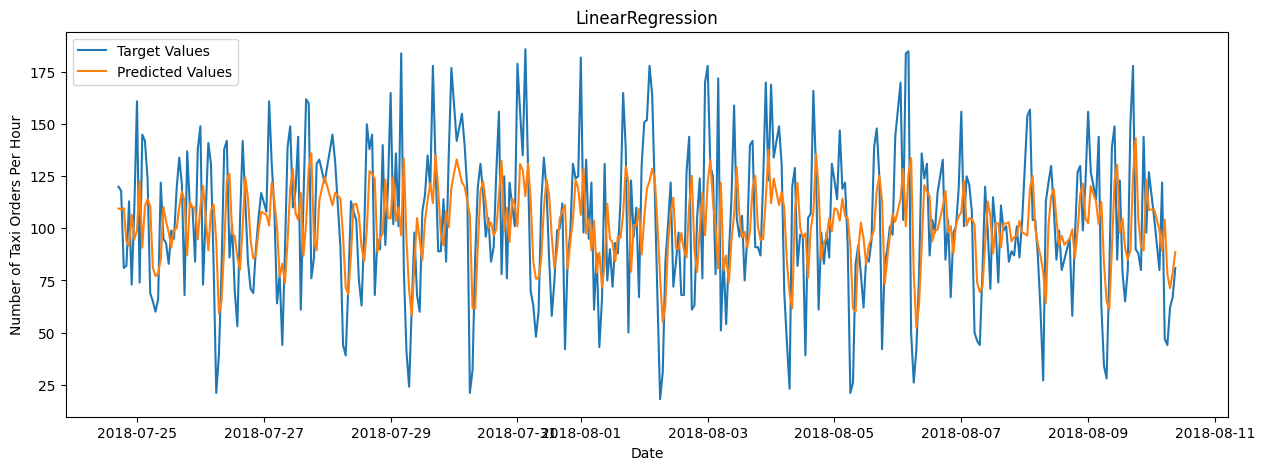


Run Time for LinearRegression:
CPU times: user 432 ms, sys: 69.3 ms, total: 501 ms
Wall time: 522 ms


In [14]:
%%time 

# Initialize Model
model = LinearRegression()

# Fit Model to Training Data
model.fit(features_train, target_train)

# Predict Test Target
predicted_values = model.predict(features_valid)

# Calculate RMSE
RMSE = np.sqrt(mean_squared_error(target_valid, predicted_values))

# Print RMSE Score
print('The RMSE for the LinearRegression Model is:', round(RMSE,2))

# Create plot that shows predicted vs actuals for validation set
# Convert predictions and acutals to list
actual = target_valid.tolist() #y-axis
predicted = predicted_values.tolist() #y-axis
x_axis = target_valid.index.tolist() #x-axis

# Configurations for plotting
plt.figure(figsize=(15, 5))
plt.plot(x_axis, actual, label = "Target Values") 
plt.plot(x_axis, predicted, label = "Predicted Values")

# Add titles
plt.xlabel("Date")
plt.ylabel("Number of Taxi Orders Per Hour")
plt.title('LinearRegression')

# Plot
plt.legend()
plt.show()

# Print Time Elapsed For Model Runtime
print()
print('Run Time for LinearRegression:')

#### RandomForrest
Evaluate the performance of a tree-based algorithm with hyperparameter tuning. **Random Forest Regression** is a versatile machine-learning technique for predicting numerical values. It combines the predictions of multiple decision trees to reduce overfitting and improve accuracy.

Best Parameters For RandomForestRegressor : {'max_depth': 20, 'n_estimators': 20}
These Parameters Produced a Best RMSE Score of -26.73 on the Training Data

The RMSE Using the Tuned RandomForestRegressor on the Validation Set: 24.6



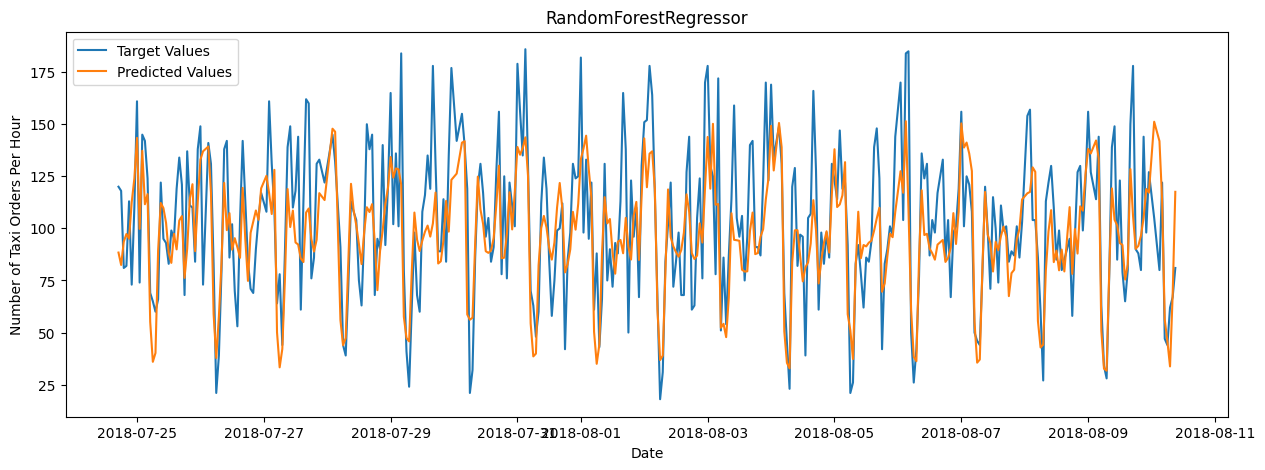


Training Time for RandomForestRegressor :
CPU times: user 2.48 s, sys: 32.9 ms, total: 2.52 s
Wall time: 2.55 s


In [15]:
%%time

# Set variables to RandomForestRegressor
model = RandomForestRegressor()
model_name = 'RandomForestRegressor'

# Configure model_evaluation to use RandomForestRegressor
model_evaluation(model, model_name)

#### LightGBM
**LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

 - Faster training speed and higher efficiency.
 - Lower memory usage.
 - Better accuracy.
 - Support of parallel, distributed, and GPU learning.
 - Capable of handling large-scale data.

Best Parameters For LGBMRegressor : {'max_depth': 10, 'n_estimators': 20}
These Parameters Produced a Best RMSE Score of -26.88 on the Training Data

The RMSE Using the Tuned LGBMRegressor on the Validation Set: 26.21



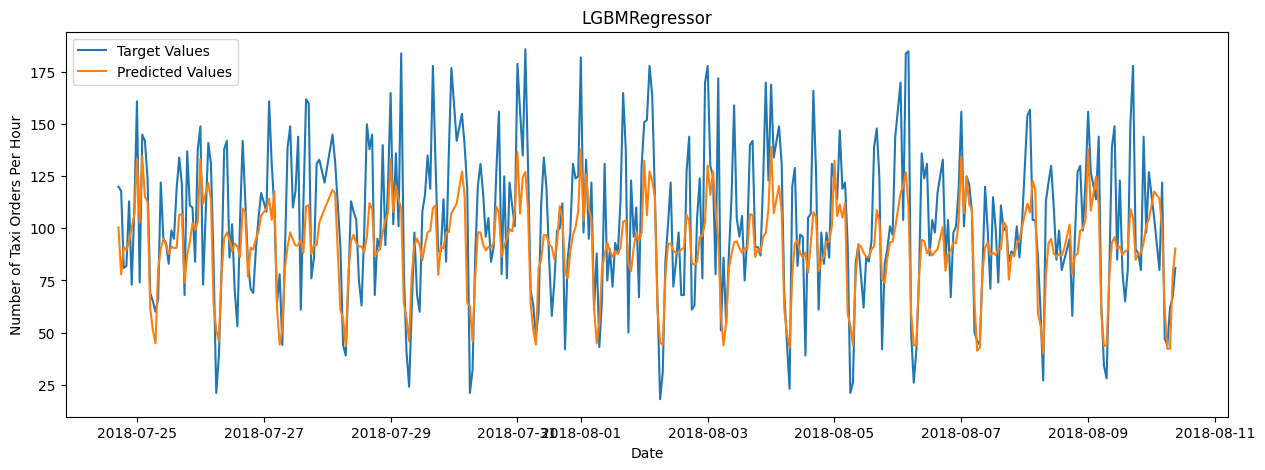


Training Time for LGBMRegressor :
CPU times: user 1.48 s, sys: 33.9 ms, total: 1.51 s
Wall time: 1.55 s


In [16]:
%%time

# Set variables to LGBMRegressor
model = LGBMRegressor(random_state=12345)
model_name = 'LGBMRegressor'

# Configure model_evaluation to use LGBMRegressor
model_evaluation(model, model_name)

#### CatBoost

**CatBoost** is a popular and high-performance open-source implementation of the Gradient Boosting Decision Tree (GBDT) algorithm. GBDT is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. CatBoost introduces two critical algorithmic advances to GBDT:

 - The implementation of ordered boosting, a permutation-driven alternative to the classic algorithm
 - An innovative algorithm for processing categorical features

Both techniques were created to fight a prediction shift caused by a special kind of target leakage present in all currently existing implementations of gradient boosting algorithms.

Learning rate set to 0.5
0:	learn: 24.3109296	total: 47.4ms	remaining: 190ms
1:	learn: 21.8861129	total: 48.7ms	remaining: 73ms
2:	learn: 20.5694651	total: 49.8ms	remaining: 33.2ms
3:	learn: 19.6954397	total: 50.8ms	remaining: 12.7ms
4:	learn: 19.4018148	total: 51.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.8082833	total: 1.7ms	remaining: 6.79ms
1:	learn: 24.5058925	total: 3.27ms	remaining: 4.91ms
2:	learn: 22.5357518	total: 4.6ms	remaining: 3.07ms
3:	learn: 21.5218956	total: 6ms	remaining: 1.5ms
4:	learn: 21.1776417	total: 7.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 24.3109296	total: 1.21ms	remaining: 10.9ms
1:	learn: 21.8861129	total: 2.29ms	remaining: 9.17ms
2:	learn: 20.5694651	total: 3.34ms	remaining: 7.79ms
3:	learn: 19.6954397	total: 4.47ms	remaining: 6.7ms
4:	learn: 19.4018148	total: 5.6ms	remaining: 5.6ms
5:	learn: 19.1403527	total: 6.83ms	remaining: 4.56ms
6:	learn: 18.6104807	total: 8.11ms	remaining: 3.47ms
7:	learn: 18.2017957	total: 9.29ms	remainin

/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/envs/python3/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_pa

0:	learn: 28.1074200	total: 1.79ms	remaining: 7.16ms
1:	learn: 25.6560571	total: 3.63ms	remaining: 5.45ms
2:	learn: 24.5258349	total: 5.24ms	remaining: 3.49ms
3:	learn: 23.2647306	total: 6.83ms	remaining: 1.71ms
4:	learn: 22.7229578	total: 8.5ms	remaining: 0us
Best Parameters For CatBoostRegressor : {'max_depth': 5, 'n_estimators': 5}
These Parameters Produced a Best RMSE Score of -28.59 on the Training Data

The RMSE Using the Tuned CatBoostRegressor on the Validation Set: 28.9



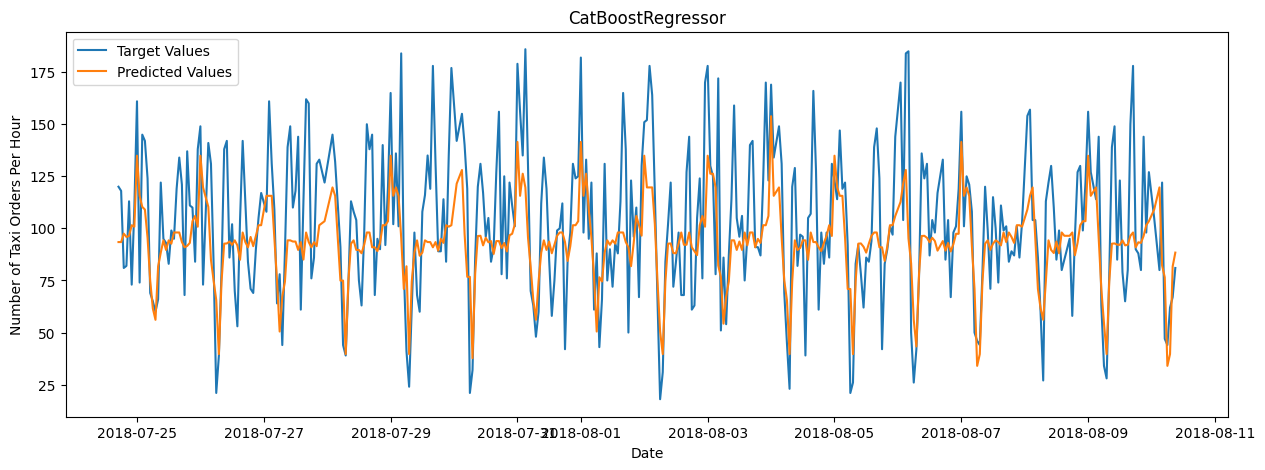


Training Time for CatBoostRegressor :
CPU times: user 1.74 s, sys: 59.6 ms, total: 1.8 s
Wall time: 2.84 s


In [17]:
%%time

# Set variables to CatBoostRegressor
model = CatBoostRegressor(random_state=12345)
model_name = 'CatBoostRegressor'

# Configure model_evaluation to use CatBoostRegressor
model_evaluation(model, model_name)

#### XGBoost
**XGBoost** is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

Best Parameters For XGBRegressor : {'max_depth': 5, 'n_estimators': 20}
These Parameters Produced a Best RMSE Score of -26.77 on the Training Data

The RMSE Using the Tuned XGBRegressor on the Validation Set: 24.34



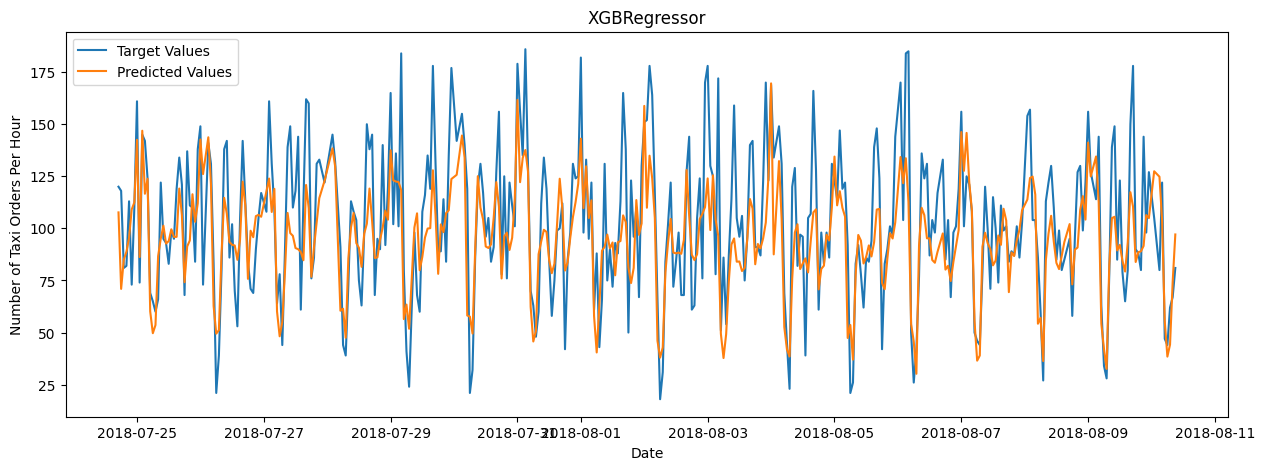


Training Time for XGBRegressor :
CPU times: user 4.99 s, sys: 58.2 ms, total: 5.05 s
Wall time: 5.13 s


In [18]:
%%time

# Set variables to XGBRegressor
model = XGBRegressor(random_state=12345)
model_name = 'XGBRegressor'

# Configure model_evaluation to use XGBRegressor
model_evaluation(model, model_name)

#### Model Training Results 

**Recall that that The Sweet Lift Taxi company has collected historical data on taxi orders at airports.** To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. **The task was to build a model that predicts taxi orders during peak hours and evaluation of the models should be scored using RMSE where the test set should not be more than 48.**

| Model            | RMSE When Predicting Targets on Validation Set | Hyperparameter Tuning Notes           | Training & Prediction Time |
|------------------|------------------------------------------------|---------------------------------------|----------------------------|
| LinearRegression | 32.84                                          | N/A                                   | 577 ms                     |
| RandomForrest    | 24.7                                           | {'max_depth': 10, 'n_estimators': 20} | 2.39 s                     |
| LightGBM         | 26.21                                          | {'max_depth': 10, 'n_estimators': 20} | 1min 51s                   |
| CatBoost         | 24.03                                          | {'max_depth': 5, 'n_estimators': 20}  | 3.14 s                     |
| XGBoost          | 24.34                                          | {'max_depth': 5, 'n_estimators': 20}  | 2min 1s                    |

The results of the regression models look promising for forecasting and predicting time series data. Given the Sweet Lift Taxi Company's requirements for model selection, **the best model for predicting the the hourly number of taxi orders at airports is the CatBoost Regression Model**. This model, when fit to the training data, produces the lowest RMSE when predicting target values on the validation set. Becuase, XGBoost had the second lowest RMSE and a reasonable training time, I will evaluate how this model performs in predicting test targets and the speed at which it predicts the targets too. 

## Evaluate RMSE For Predicting Test Targets

**Using the results of the previous section,** I will select the models with the lowest RMSE and predict the test values using the hyperparamters that we found to be optimal. We will also reuse the LinearRegression model to predict the test values and find an RMSE so that we can compare with the models.

### CatBoostRegressor - Test Data Evaluation

In [19]:
%%time 

# Initialize Model
# Use hyperparameters from tuning
model = CatBoostRegressor(random_state=12345, n_estimators = 10, max_depth = 5, verbose = 0)

# Fit model to training data
model.fit(features_train, target_train)

# Predict target values on the test set
predicted_values = model.predict(features_test)

# Calculate RMSE between predicted target and actual target for test set
RMSE = np.sqrt(mean_squared_error(target_test, predicted_values))

print("The RMSE Using the Tuned CatBoostRegressor on the Test Set:", round(RMSE,2))
print()
print('Training Time for CatBoostRegressor:')

The RMSE Using the Tuned CatBoostRegressor on the Test Set: 37.96

Training Time for CatBoostRegressor:
CPU times: user 24 ms, sys: 4.04 ms, total: 28.1 ms
Wall time: 98.2 ms


### XGBRegressor - Test Data Evaluation

In [20]:
%%time 

# Initialize Model
# Use hyperparameters from tuning
model = XGBRegressor(random_state=12345, n_estimators = 20, max_depth = 5, verbose = 0)

# Fit model to training data
model.fit(features_train, target_train)

# Predict target values on the test set
predicted_values = model.predict(features_test)

# Calculate RMSE between predicted target and actual target for test set
RMSE = np.sqrt(mean_squared_error(target_test, predicted_values))

print("The RMSE Using the Tuned XGBRegressor on the Test Set:", round(RMSE,2))
print()
print('Training Time for XGBRegressor:')

[01:46:09] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


The RMSE Using the Tuned XGBRegressor on the Test Set: 37.43

Training Time for XGBRegressor:
CPU times: user 280 ms, sys: 4.79 ms, total: 285 ms
Wall time: 259 ms


## Conlcusion 

Given the results generated in section 7, **I would recommend the Sweet Lift Taxi Company implement a XGBoost model if it wants to produce results with the least amount of error (lowest RMSE). However, if the Sweet Lift Taxi Company is concerned with the speed of predictions, the CatBoost model produced a similiar RMSE (within 2% difference) but makes the prediction in half the time.**

| Model    | RMSE When Predicting Targets on Test Set | Prediction Speed |
|----------|------------------------------------------|------------------|
| CatBoost | 37.96                                    | 111 ms           |
| XGBoost  | 37.43                                    | 224 ms           |